In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def softmax(t):
    res = np.exp(t)
    return res / np.sum(res)

def relu(t):
    return np.maximum(t, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1-sigmoid(x))

def relu_deriv(t):
    return (t>=0).astype(float)


class Perceptron:
    def __init__(self, input_dim, h1_dim, h2_dim, out_dim, learn_rate = 0.05):
        self.input_dim = input_dim
        self.h1_dim = h1_dim
        self.h2_dim = h2_dim
        self.out_dim = out_dim
        self.learn_rate = learn_rate

        self.t1 = np.zeros([1, self.h1_dim])
        self.h1 = np.zeros([1, self.h1_dim])
        self.t2 = np.zeros([1, self.h2_dim])
        self.h2 = np.zeros([1, self.h2_dim])
        self.t3 = np.zeros([1, self.out_dim])
        self.out = np.zeros([1, self.out_dim])

        self.w1 = np.random.normal(size = (self.input_dim, self.h1_dim)) * 0.1
        self.b1 = np.random.normal(size = (1, self.h1_dim)) * 0.1
        self.w2 = np.random.normal(size = (self.h1_dim, self.h2_dim)) * 0.1
        self.b2 = np.random.normal(size = (1, self.h2_dim)) * 0.1
        self.w3 = np.random.normal(size = (self.h2_dim, self.out_dim)) * 0.1
        self.b3 = np.random.normal(size = (1, self.out_dim)) * 0.1
        self.drop_gradients()


    def drop_gradients(self):
        self.dE_dw1 = np.zeros((self.input_dim, self.h1_dim))
        self.dE_db1 = np.zeros((1, self.h1_dim))
        self.dE_dw2 = np.zeros((self.h1_dim, self.h2_dim))
        self.dE_db2 = np.zeros((1, self.h2_dim))
        self.dE_dw3 = np.zeros((self.h2_dim, self.out_dim))
        self.dE_db3 = np.zeros((1, self.out_dim))


    def run(self, data, activation_function):
        self.t1 = data * self.w1 + self.b1
        self.h1 = activation_function(self.t1)
        self.t2 = self.h1 @ self.w2 + self.b2
        self.h2 = activation_function(self.t2)
        self.t3 = self.h2 @ self.w3 + self.b3
        self.out = self.t3
        return self.out



    def calculate_gradient(self, data, right_out, activation_deriv):
        dE_dt3 = self.out - right_out
        self.dE_dw3 += self.h2.T @ dE_dt3
        self.dE_db3 = dE_dt3

        dE_dh2 = dE_dt3 @ self.w3.T
        dE_dt2 = dE_dh2 * activation_deriv(self.t2)
        self.dE_dw2 += self.h1.T @ dE_dt2
        self.dE_db2 += dE_dt2

        dE_dh3 = dE_dt2 @ self.w2.T
        dE_dt3 = dE_dh3 * activation_deriv(self.t1)
        self.dE_dw1 += data.T * dE_dt3
        self.dE_db1 += dE_dt3


    def apply_gradient(self, batch_size=1):
        self.w1 -= self.learn_rate * self.dE_dw1 / batch_size
        self.w2 -= self.learn_rate * self.dE_dw2 / batch_size
        self.w3 -= self.learn_rate * self.dE_dw3 / batch_size
        self.b1 -= self.learn_rate * self.dE_db1 / batch_size
        self.b2 -= self.learn_rate * self.dE_db2 / batch_size
        self.b3 -= self.learn_rate * self.dE_db3 / batch_size

        self.drop_gradients()



In [49]:
def train_model(model, X_train, y_train, X_test, y_test):
    for epoch in range (1, 1000):
        loss = 0
        inner_counter = 1
        for i in np.random.permutation(len(X_train)):
            prediction = model.run(data=X_train[i].flatten(), activation_function=relu)
            loss += np.sum(np.square(y_train[i] - prediction[0][0])/2)
            model.calculate_gradient(data=X_train[i], right_out=y_train[i].flatten(), activation_deriv=relu_deriv)
            if inner_counter % 10 == 0:
                model.apply_gradient(batch_size=10)
            inner_counter += 1

        test_loss = 0
        # for i in range(0, 10000):
        #     prediction = np.argmax(model.run(data=X_test[i], activation_function=relu))
        #     test_loss += (y_test[i] - prediction) ** 2
        print(f"Epoch №{epoch} finished with accuracy {round(loss/len(X_train), 6)} Test dataset accuracy {round(test_loss/len(X_train) * 100, 2)}")


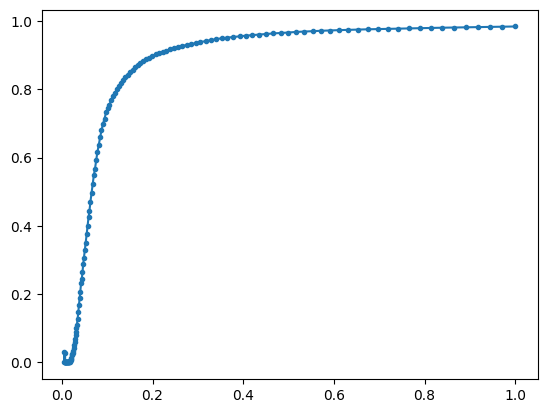

In [50]:
import pandas as pd
P_START = 21
dataframe_sorb = pd.read_excel('Silica-loc-isoth1.xlsx', header=None, sheet_name="Adsorption")
AX_train = []
PX_train = []
pore_N = dataframe_sorb.shape[1]

p_array = np.array(dataframe_sorb[0][21:])
a_array = np.array(dataframe_sorb.iloc[0][1:])
a_scale = np.max(a_array)
a_array = a_array / a_scale

pi_x_array = np.empty((len(a_array), len(p_array)))
pi_a_array = np.empty((len(a_array), len(p_array)))
for i in range(len(a_array)):
    pi_x_array[i] = p_array
    pi_a_array[i] = dataframe_sorb[i+1][21:]

    
step_array = np.empty(shape=a_array.shape)
for i, pi_a in enumerate(pi_a_array):
    pi_change = - pi_a[:-1] + pi_a[1:]
    step_array[i] = p_array[np.argmax(pi_change)]
plt.plot(a_array, step_array, marker=".")

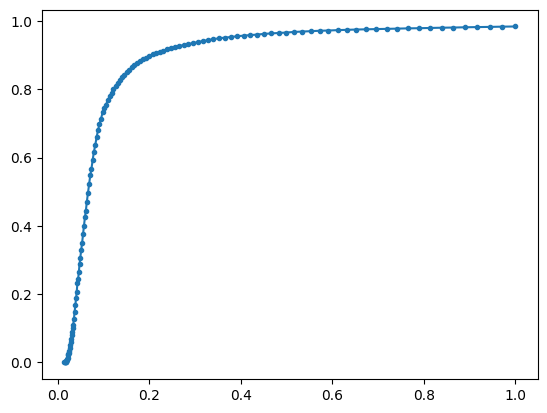

In [65]:
a_train = a_array[20:]
step_array_train = step_array[20:]
plt.plot(a_train, step_array_train, marker=".")

In [66]:
np.random.seed(0)
model = Perceptron(input_dim=1, h1_dim=100, h2_dim=100, out_dim=1)

In [67]:
model.learn_rate = 0.1
train_model(model, a_train, step_array_train, a_train, step_array_train)

Epoch №1 finished with accuracy 0.1221 Test dataset accuracy 0.0
Epoch №2 finished with accuracy 0.060231 Test dataset accuracy 0.0
Epoch №3 finished with accuracy 0.057053 Test dataset accuracy 0.0
Epoch №4 finished with accuracy 0.055736 Test dataset accuracy 0.0
Epoch №5 finished with accuracy 0.052388 Test dataset accuracy 0.0
Epoch №6 finished with accuracy 0.050348 Test dataset accuracy 0.0
Epoch №7 finished with accuracy 0.047197 Test dataset accuracy 0.0
Epoch №8 finished with accuracy 0.044828 Test dataset accuracy 0.0
Epoch №9 finished with accuracy 0.043089 Test dataset accuracy 0.0
Epoch №10 finished with accuracy 0.041086 Test dataset accuracy 0.0
Epoch №11 finished with accuracy 0.040128 Test dataset accuracy 0.0
Epoch №12 finished with accuracy 0.039763 Test dataset accuracy 0.0
Epoch №13 finished with accuracy 0.036765 Test dataset accuracy 0.0
Epoch №14 finished with accuracy 0.036588 Test dataset accuracy 0.0
Epoch №15 finished with accuracy 0.035206 Test dataset accu

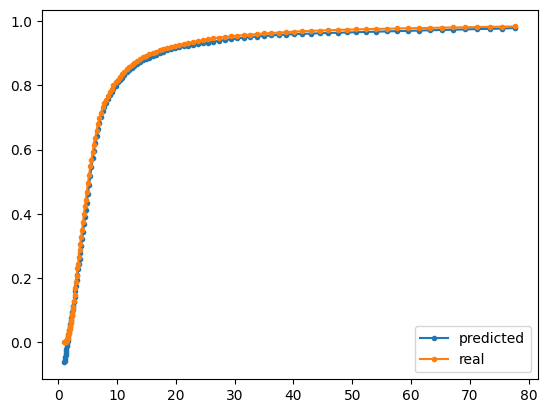

In [70]:
predicted_step = np.empty(shape=a_train.shape)
for i in range(len(a_train)):
    predicted_step[i] = model.run(data=a_train[i], activation_function=relu)
plt.plot(a_train*a_scale, predicted_step, marker=".", label="predicted")
plt.plot(a_train*a_scale, step_array_train, marker=".", label="real")
plt.legend()

In [ ]:
# right_answer = []
# for i in X_train:
#     right_answer.append(model.run(data=i.flatten(), activation_function=relu)[0][0]*y_scale)
# plt.plot(X_train*10, Y_train*y_scale, marker=".")
# plt.plot(X_train*10, right_answer, marker=".")

In [ ]:
# import PyQt5
# %matplotlib notebook
#
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# X, Y = np.meshgrid(AX_train, PX_train)
# Z = Y_train.reshape(X.shape)
# surf = ax.plot_surface(X, Y, Z)
# plt.show()